# Demo 6 — Computer Vision with CNNs (Image Classification)

**Notebook Link (insert before submission):** 

**Author:** Thanakrit Intharabut  


---

## What this notebook includes (matches assignment criteria)
- Clear **problem statement**, **goal**, and **AI technique** explanation (CNNs) in context  
- Fully annotated code cells with **Markdown explanations above each code segment**  
- A complete **demo** solving an image classification problem using a CNN on a standard dataset  
- **Key parameters** explained (learning rate, batch size, epochs, architecture choices)  
- **Evaluation outputs** (accuracy, confusion matrix, example predictions)  
- **How to export to PDF** (cell provided near the end)  
- **Short video talking points** you can use to record your 3–5 minute demo video (presenter in frame)

> If you use Google Colab: **Runtime → Change runtime type → GPU** for faster training.

## 1. Problem Statement
We build a **computer vision classifier** that recognises the class of an image from a benchmark dataset (we'll use **CIFAR-10**: 10 everyday object categories such as airplane, car, bird, cat, etc.).  
We will split the data into training, validation, and test sets; train a **Convolutional Neural Network (CNN)**; and evaluate generalisation.

### Inputs
- RGB images (32×32) with 3 channels.

### Output
- Predicted class label among 10 categories.

## Goal
- Train a CNN that achieves **≥70% test accuracy** on CIFAR-10 within a short training time on GPU (or CPU if necessary with fewer epochs).
- Show **evaluation plots**, a **confusion matrix**, and **example predictions**.

## 2. AI Technique Chosen — Convolutional Neural Networks (CNNs)
**Why CNNs?**  
CNNs exploit **spatial locality** via convolutional filters, learning translation‑aware features (edges → textures → parts → objects). Compared to fully‑connected networks, CNNs dramatically reduce parameters and overfitting for image data. Key building blocks:
- **Convolution**: learnable kernels sliding over the image to detect features.
- **Nonlinearity**: activations (ReLU) improve expressiveness.
- **Pooling**: downsample to increase receptive field and reduce computation.
- **Batch Normalisation & Dropout**: stabilise and regularise training.
- **Classification head**: global average pooling + dense layer for class logits.

We'll start with a compact CNN (in Keras/TensorFlow) suitable for CIFAR‑10.

### 3. Setup & Imports

In [13]:
# --- Versions, imports, and reproducibility (robust) ---

# (Optional) inline plotting in notebooks
# %matplotlib inline

import os, sys, json, time, math, random
import numpy as np
import matplotlib.pyplot as plt

# Quiet TensorFlow logs
os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "2")  # 0=all,1=info,2=warnings,3=errors
# (Optional) more deterministic ops
os.environ.setdefault("TF_DETERMINISTIC_OPS", "1")

# Try TensorFlow first; if missing (e.g., local Jupyter), install CPU TF as a fallback
try:
    import tensorflow as tf
except Exception as e:
    print("TensorFlow not found; installing a compatible version (CPU).")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "tensorflow==2.15.0"])
    import tensorflow as tf

# Prefer tf.keras; if unavailable (Keras 3 standalone), fall back to `keras`
try:
    from tensorflow import keras
    from tensorflow.keras import layers
    _KERAS_BACKEND = "tf.keras"
except Exception:
    import keras  # standalone Keras 3.x
    from keras import layers
    _KERAS_BACKEND = "keras (standalone)"

# Print versions
print("Python      :", sys.version.split()[0])
print("NumPy       :", np.__version__)
print("Matplotlib  :", plt.matplotlib.__version__)
print("TensorFlow  :", getattr(tf, "__version__", "N/A"))
print("Keras (API) :", _KERAS_BACKEND, getattr(keras, "__version__", "N/A"))

# Device info
try:
    gpus = tf.config.list_physical_devices('GPU')
    tpus = tf.config.list_logical_devices('TPU')
    if gpus:
        print(f"GPU(s)     : {len(gpus)} detected →", gpus)
    elif tpus:
        print("TPU        : detected")
    else:
        print("GPU/TPU    : none detected (using CPU)")
except Exception as _:
    pass

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
try:
    tf.random.set_seed(SEED)
except Exception:
    pass


Python      : 3.10.11
NumPy       : 1.24.4
Matplotlib  : 3.10.3
TensorFlow  : 2.15.0
Keras (API) : tf.keras N/A
GPU/TPU    : none detected (using CPU)


### 4. Load CIFAR-10 dataset
We use the CIFAR‑10 dataset bundled with Keras. We'll normalise pixel values to [0,1], and create a separate validation split from the training set.

In [14]:
# Load data
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
y_train = y_train.flatten()
y_test = y_test.flatten()

# Normalise to [0,1]
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32")  / 255.0

# Build validation split
VAL_RATIO = 0.1
num_val = int(len(x_train) * VAL_RATIO)
x_val, y_val = x_train[:num_val], y_train[:num_val]
x_train2, y_train2 = x_train[num_val:], y_train[num_val:]

class_names = ["airplane","automobile","bird","cat","deer",
               "dog","frog","horse","ship","truck"]

print("Train:", x_train2.shape, y_train2.shape)
print("Val  :", x_val.shape, y_val.shape)
print("Test :", x_test.shape,  y_test.shape)

Train: (45000, 32, 32, 3) (45000,)
Val  : (5000, 32, 32, 3) (5000,)
Test : (10000, 32, 32, 3) (10000,)


### 5. Quick look at sample images

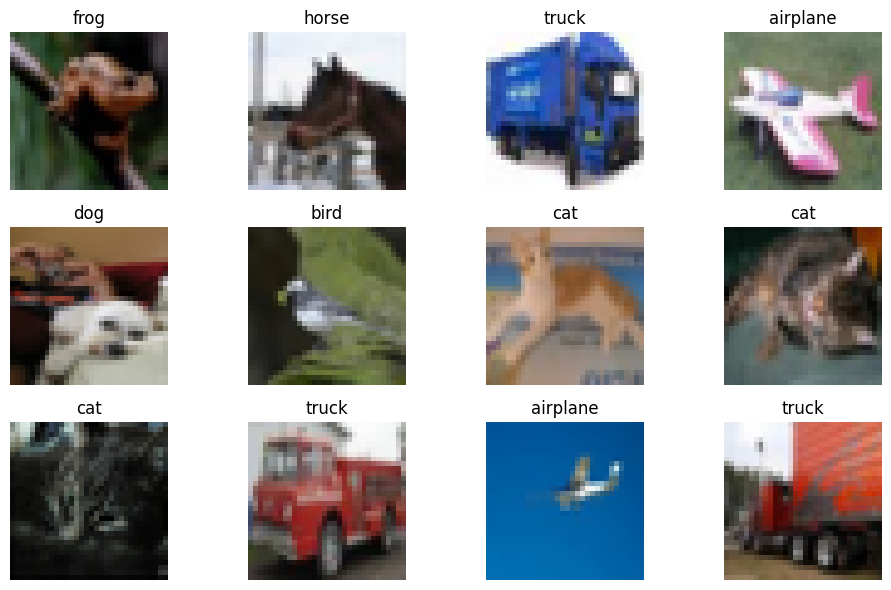

In [15]:
# Show a few examples
def show_examples(images, labels, n=12):
    plt.figure(figsize=(10, 6))
    for i in range(n):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(images[i])
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_examples(x_train2, y_train2, n=12)

## 6. CNN architecture
We use a compact CNN that balances accuracy and speed:
- 3 × blocks of **Conv → BN → ReLU → Conv → BN → ReLU → MaxPool → Dropout**
- **GlobalAveragePooling** before a Dense softmax for classification
- Optimiser: **Adam** (learning rate 1e-3 by default)
- Loss: **SparseCategoricalCrossentropy**

> **Key parameters to tune:** learning rate, batch size, number of filters, dropout rate, and epochs.

In [16]:
def build_cnn(input_shape=(32,32,3), num_classes=10):
    inputs = keras.Input(shape=input_shape)

    def block(x, filters):
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.MaxPooling2D()(x)
        x = layers.Dropout(0.25)(x)
        return x

    x = block(inputs, 32)
    x = block(x, 64)
    x = block(x, 128)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="cifar10_cnn")
    return model

model = build_cnn()
model.summary()

Model: "cifar10_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_6 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 re_lu_6 (ReLU)              (None, 32, 32, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_7 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                      

### 7. Compile & train
We use:
- `Adam` optimiser (default lr=1e-3)  
- `SparseCategoricalCrossentropy` loss  
- Metrics: `accuracy`

Callbacks:
- **EarlyStopping** (monitor val\_accuracy, patience=5, restore best weights)  
- **ReduceLROnPlateau** (reduce LR when val\_loss plateaus)  
- **ModelCheckpoint** (save best model)

In [5]:
BATCH_SIZE = 128
EPOCHS = 30

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

ckpt_path = "best_cifar10_cnn.keras"
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1),
    keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_accuracy", save_best_only=True, verbose=1),
]

history = model.fit(
    x_train2, y_train2,
    validation_data=(x_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=2
)

Epoch 1/30



Epoch 1: val_accuracy improved from -inf to 0.23940, saving model to best_cifar10_cnn.keras
352/352 - 84s - loss: 1.5037 - accuracy: 0.4561 - val_loss: 2.5604 - val_accuracy: 0.2394 - lr: 0.0010 - 84s/epoch - 239ms/step
Epoch 2/30

Epoch 2: val_accuracy improved from 0.23940 to 0.58900, saving model to best_cifar10_cnn.keras
352/352 - 74s - loss: 1.0944 - accuracy: 0.6068 - val_loss: 1.1429 - val_accuracy: 0.5890 - lr: 0.0010 - 74s/epoch - 211ms/step
Epoch 3/30

Epoch 3: val_accuracy improved from 0.58900 to 0.63220, saving model to best_cifar10_cnn.keras
352/352 - 72s - loss: 0.9576 - accuracy: 0.6606 - val_loss: 1.0506 - val_accuracy: 0.6322 - lr: 0.0010 - 72s/epoch - 203ms/step
Epoch 4/30

Epoch 4: val_accuracy improved from 0.63220 to 0.66360, saving model to best_cifar10_cnn.keras
352/352 - 69s - loss: 0.8663 - accuracy: 0.6958 - val_loss: 0.9405 - val_accuracy: 0.6636 - lr: 0.0010 - 69s/epoch - 196ms/step
Epoch 5/30

Epoch 5: val_accuracy improved from 0.66360 to 0.

### 8. Learning curves

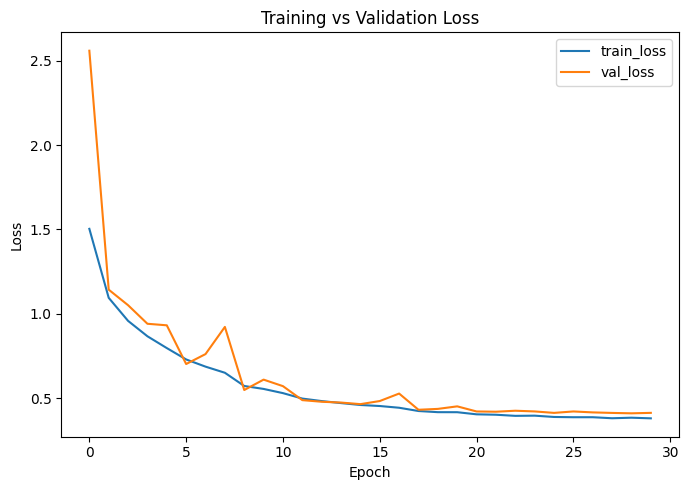

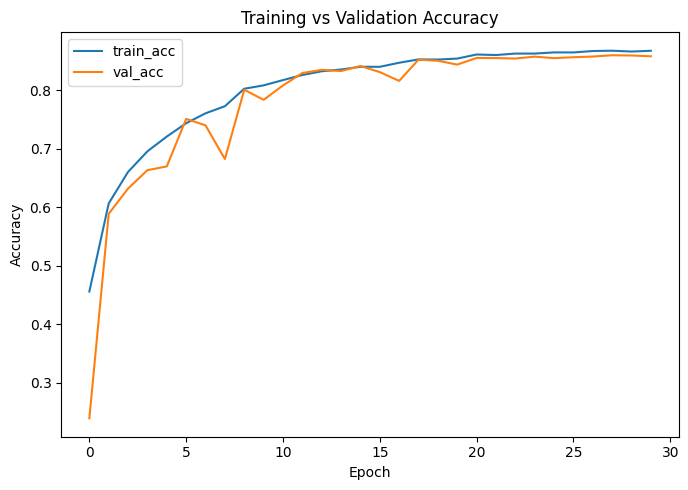

In [6]:
def plot_history(hist):
    h = hist.history
    plt.figure(figsize=(7,5))
    plt.plot(h["loss"], label="train_loss")
    plt.plot(h["val_loss"], label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7,5))
    plt.plot(h["accuracy"], label="train_acc")
    plt.plot(h["val_accuracy"], label="val_acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_history(history)

## 9. Evaluation on Test Set
We report accuracy and show a confusion matrix.

Test accuracy: 0.8527 | Test loss: 0.4398


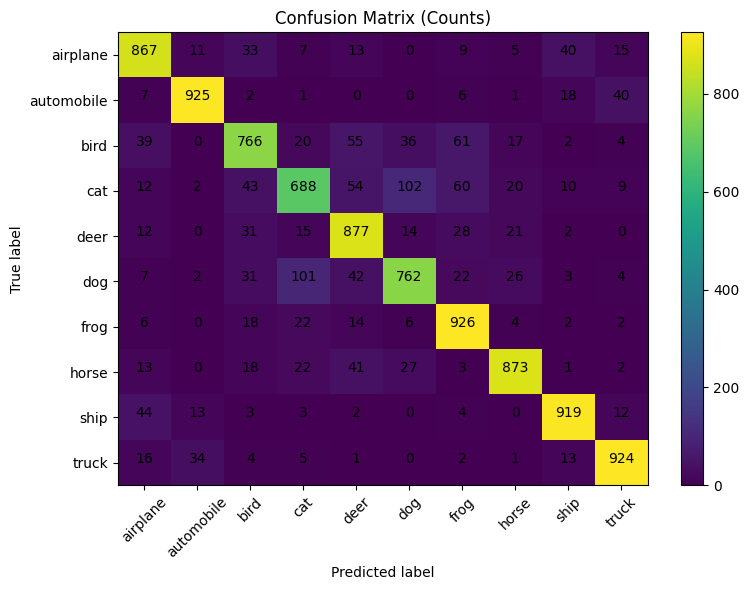

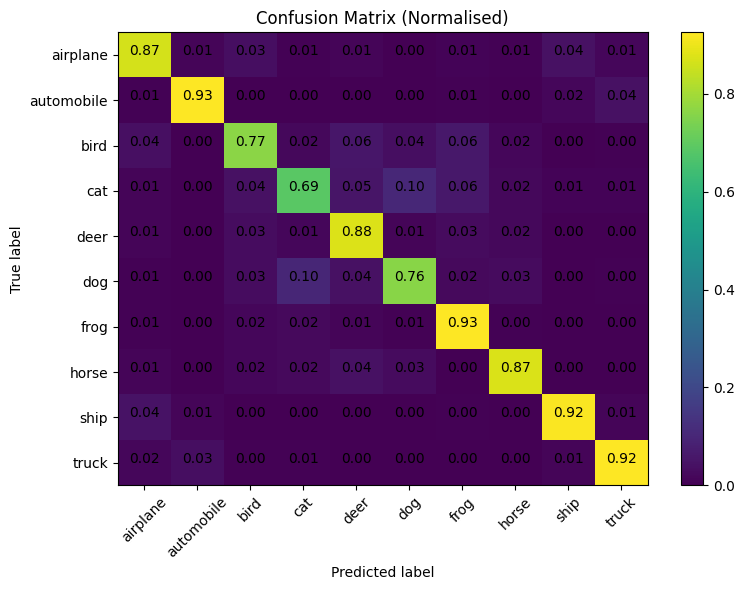

              precision    recall  f1-score   support

    airplane       0.85      0.87      0.86      1000
  automobile       0.94      0.93      0.93      1000
        bird       0.81      0.77      0.79      1000
         cat       0.78      0.69      0.73      1000
        deer       0.80      0.88      0.84      1000
         dog       0.80      0.76      0.78      1000
        frog       0.83      0.93      0.87      1000
       horse       0.90      0.87      0.89      1000
        ship       0.91      0.92      0.91      1000
       truck       0.91      0.92      0.92      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [7]:
from sklearn.metrics import confusion_matrix, classification_report
import itertools

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f} | Test loss: {test_loss:.4f}")

y_pred_probs = model.predict(x_test, batch_size=256, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, class_names, normalize=False, title='Confusion Matrix (Counts)')
plot_confusion_matrix(cm, class_names, normalize=True,  title='Confusion Matrix (Normalised)')

print(classification_report(y_test, y_pred, target_names=class_names))

### 10. Example predictions
We display a few test images with predicted vs true labels.

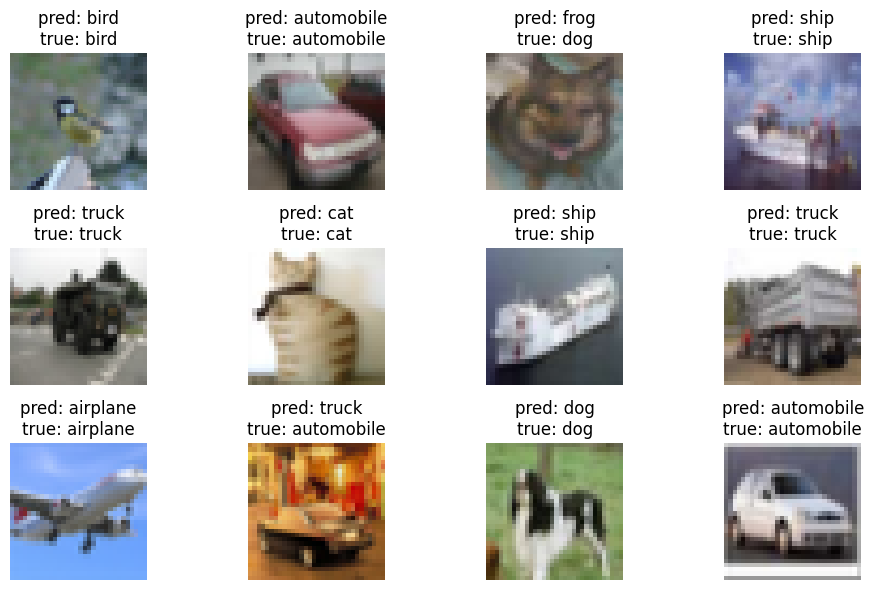

In [8]:
def show_predictions(images, y_true, y_pred, n=12):
    idx = np.random.choice(len(images), n, replace=False)
    plt.figure(figsize=(10, 6))
    for i, k in enumerate(idx):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[k])
        title = f"pred: {class_names[y_pred[k]]}\ntrue: {class_names[y_true[k]]}"
        plt.title(title)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Call the function
show_predictions(x_test, y_test, y_pred, n=12)


### 11. (Optional) Explainability via Grad‑CAM
We compute a simple Grad‑CAM heatmap for one correctly predicted image to visualise where the CNN looked.

Last conv layer: conv2d_5


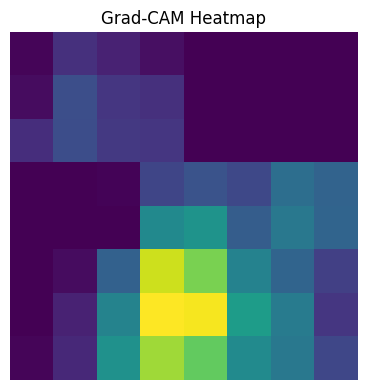

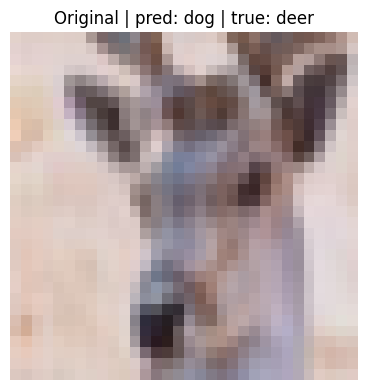

In [9]:
# Simple Grad-CAM for last conv layer
def get_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, layers.Conv2D):
            return layer.name
    return None

last_conv_name = get_last_conv_layer(model)
print("Last conv layer:", last_conv_name)

def grad_cam(img_array, model, last_conv_layer_name):
    grad_model = keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array, training=False)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

# Pick one test image
k = np.random.randint(0, len(x_test))
img = x_test[k:k+1]
pred_label = np.argmax(model.predict(img, verbose=0), axis=1)[0]

heatmap = grad_cam(img, model, last_conv_name)

# Visualise heatmap
plt.figure(figsize=(6,4))
plt.imshow(heatmap)
plt.title("Grad-CAM Heatmap")
plt.axis("off")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.imshow(x_test[k])
plt.title(f"Original | pred: {class_names[pred_label]} | true: {class_names[y_test[k]]}")
plt.axis("off")
plt.tight_layout()
plt.show()

## 12. Save artefacts
We save the trained model and a small JSON with metrics for your report.

In [10]:
# Save model and metrics
model.save("cifar10_cnn_final.keras")
metrics = {
    "test_accuracy": float((y_pred == y_test).mean()),
    "num_params": int(model.count_params()),
    "epochs_trained": len(history.history["loss"]),
    "batch_size": int(BATCH_SIZE),
}
with open("metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("Saved: cifar10_cnn_final.keras, metrics.json, best checkpoint:", os.path.abspath("best_cifar10_cnn.keras"))

Saved: cifar10_cnn_final.keras, metrics.json, best checkpoint: c:\Users\Jeen\Desktop\introai\introai6\best_cifar10_cnn.keras


## 13. Export to PDF
Two options:
1. **Colab/Notebook UI**: File → Print → Save as PDF (recommended).
2. **nbconvert** (may require LaTeX): Run the cell below. If TeX is missing, use Option 1.

In [11]:
# Try programmatic export (may fail if LaTeX isn't installed in your environment)
# In Colab you can: !jupyter nbconvert --to pdf "Demo6_CNN.ipynb"
print("If nbconvert is available, run in a terminal/cell:")
print('!jupyter nbconvert --to pdf "Demo6_CNN.ipynb"')

If nbconvert is available, run in a terminal/cell:
!jupyter nbconvert --to pdf "Demo6_CNN.ipynb"


In [12]:
# OPTIONAL: simple augmentation pipeline
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# datagen = ImageDataGenerator(
#     rotation_range=15,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     horizontal_flip=True,
# )
# datagen.fit(x_train2)
# history = model.fit(datagen.flow(x_train2, y_train2, batch_size=BATCH_SIZE),
#                     validation_data=(x_val, y_val),
#                     epochs=EPOCHS, callbacks=callbacks, verbose=2)